In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.font_manager as mfm
import matplotlib as mpl

import numpy as np
import numpy.linalg as la

import time
import glob,os

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.autograd import Variable

from PIL import Image
from imageio import imread

font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
prop = mfm.FontProperties(fname=font_path)

# Loading data

Print labels in the dataset

In [2]:
data_dir = 'CHANGE ME' # list data path here
data_saving_path = data_dir + "_trained_result_image_24/"

os.listdir(data_dir)[0]
names = []
for j in os.listdir(data_dir):
    file = glob.glob(data_dir+"/"+ j+"/*.png")[0]        
    names.append(file)

labels = np.load(data_saving_path + "/labels.npy") # printing labels
print("Chinese charactors learned by CNN:", )
print(labels)
print(len(names))

## Get features from trained CNN 

ConvNet has 2 Convolutional layers and 2 Fully Connected layers. The model is trained in the IPython Notebook conv.ipynb and the parameters are saved.

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, depth_1, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(depth_1, depth_2, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(int(size_IMG**2/16) * depth_2, 100)
        self.fc2 = nn.Linear(100, num_classes)
        
    def forward(self, x):
        
        out = self.layer1(x)
        conv_x = self.layer2[0](out)
        
        out = self.layer2(out)
        max_pool_x = out
        
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        
        out = self.fc1(out)
        out = self.fc2(out)
               
        return out, conv_x, max_pool_x

In [6]:
size_IMG = 24
depth_1 = 16
depth_2 = 16
model = torch.load(data_saving_path + "/conv_network_model") # load model
model.eval()

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=576, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=1950, bias=True)
)

Resizing input images and converting them to a Tensor object

In [7]:
train_transforms = transforms.Compose([transforms.Resize(size_IMG),
                                       transforms.ToTensor(),
                                       ])

## Visualizing feature maps of words '名', '古', '妻'

In [13]:
def plot_feature_map(visu_conv):
    plt.figure(figsize = (10,10))
    f, axarr = plt.subplots(4,4, sharex=True)

    for i in range(4):
        for j in range(4):
            axarr[i,j].imshow(visu_conv[0][i*4+j].cpu().detach().numpy())
            axarr[i,j].axis('off')

#     plt.show()

max pool with 名 prediction: True


<Figure size 720x720 with 0 Axes>

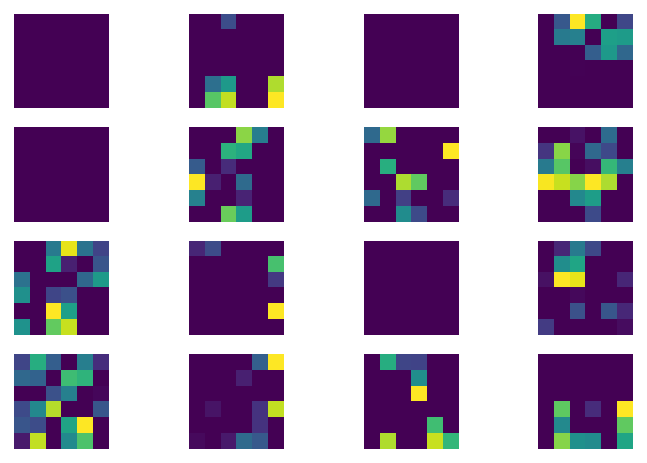

convolution layer with 名 prediction: True


<Figure size 720x720 with 0 Axes>

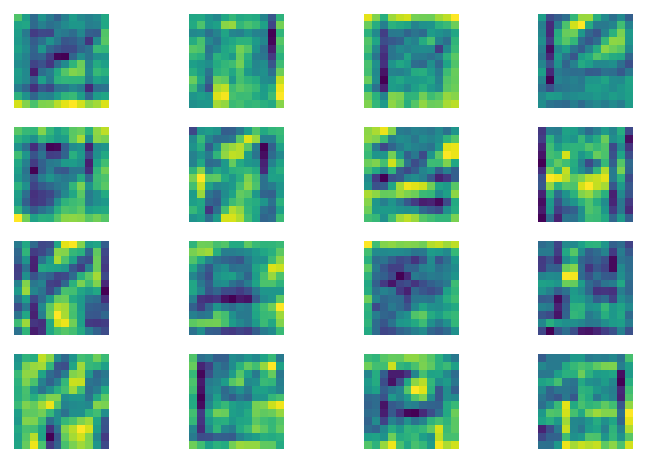

max pool with 妻 prediction: True


<Figure size 720x720 with 0 Axes>

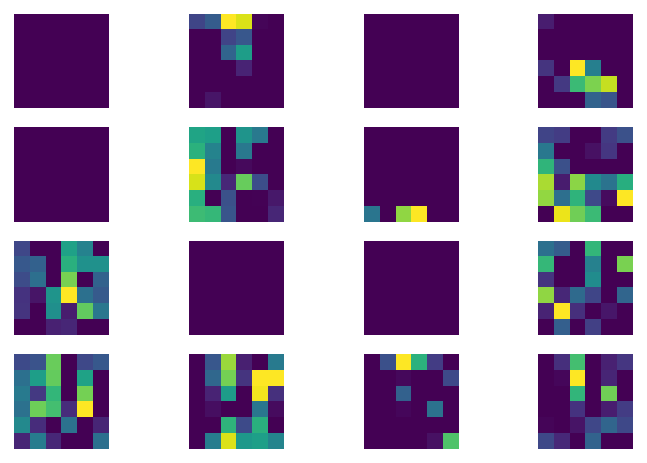

convolution layer with 妻 prediction: True


<Figure size 720x720 with 0 Axes>

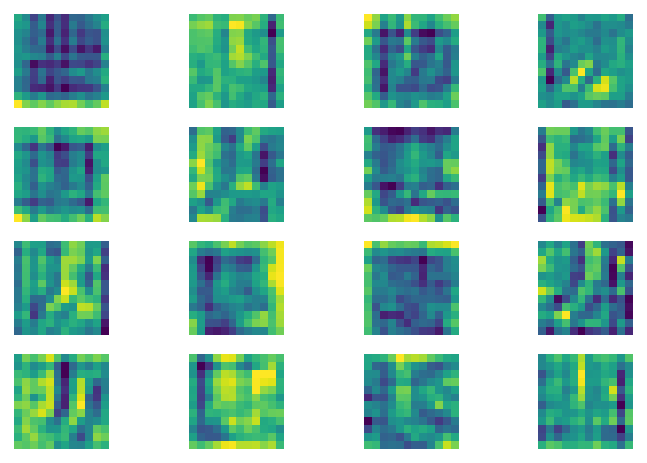

max pool with 古 prediction: True


<Figure size 720x720 with 0 Axes>

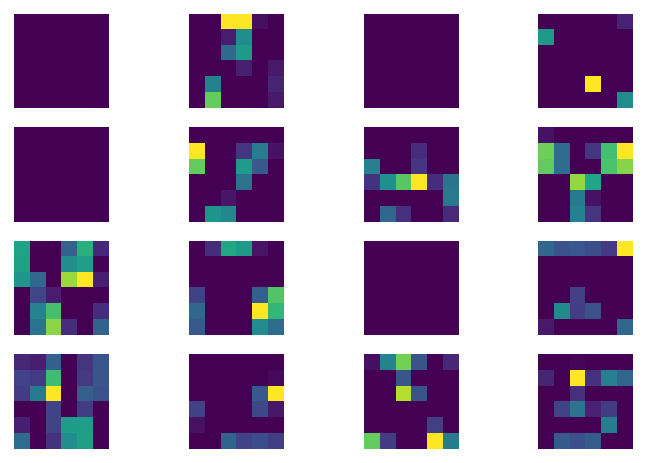

convolution layer with 古 prediction: True


<Figure size 720x720 with 0 Axes>

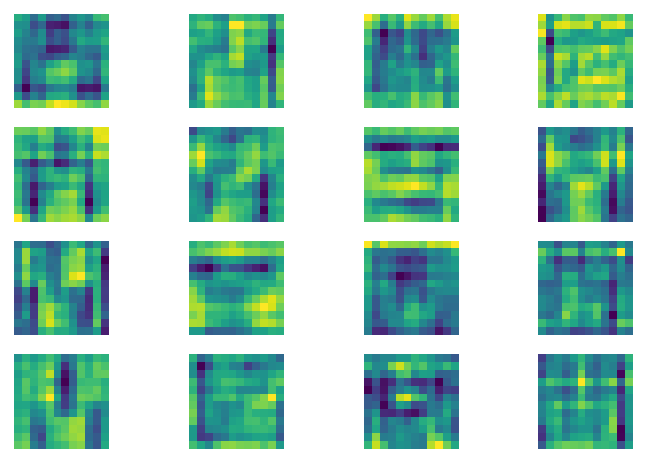

In [15]:
tot_conv = []
tot_vect_conv = []
L = []
for j in os.listdir(data_dir):
    file = glob.glob(data_dir+"/"+ j+"/*.png")[0]

    im = Image.open(file)

    tensorimage = train_transforms(im)

    outputs, visu_conv, visu_max_pool = model(tensorimage.view(1,1,size_IMG,size_IMG).cuda())

    vect_conv = visu_max_pool[0].view(-1).cpu().detach().numpy()  
    tot_vect_conv.append(vect_conv) 

    tot_conv.append(visu_max_pool[0].cpu().detach().numpy()) 

    _, predicted = torch.max(outputs.data, 1)

    L.append(j)
    if j in ['名', '古', '妻']:
        print("max pool with %s"%j, "prediction:", labels[predicted]==j)
        plot_feature_map(visu_max_pool)
        
        plt.show()
        print("convolution layer with %s"%j, "prediction:", labels[predicted]==j)
        plot_feature_map(visu_conv)
 
        plt.show()

## Clustering the feature maps using K-means

In [16]:
use_cuda = torch.cuda.is_available()
dtype = 'float32' if use_cuda else 'float64'
torchtype = {'float32': torch.float32, 'float64': torch.float64}

def KMeans(x, K=10, Niter=100, verbose=True):
    N, D = x.shape  # Number of samples, dimension of the ambient space

    # K-means loop:
    # - x  is the point cloud,
    # - cl is the vector of class labels
    # - c  is the cloud of cluster centroids
    start = time.time()
    c = x[:K, :].clone()  # Simplistic random initialization
    x_i = x[:, None, :]  # (Npoints, 1, D)
    c_prev = x[:K, :].clone()
    for i in range(Niter):

        c_j = c[None, :, :]  # (1, Nclusters, D)
        
        D_ij = ((x_i - c_j) ** 2).sum(-1)  # (Npoints, Nclusters) symbolic matrix of squared distances   
        cl = np.argmin(D_ij, axis = 1)  # Points -> Nearest cluster

        Ncl = torch.bincount(cl).type(torchtype[dtype])  # Class weights
        for d in range(D):  # Compute the cluster centroids with torch.bincount:
            c[:, d] = torch.bincount(cl, weights=x[:, d]) / Ncl
        
        if torch.all(torch.eq(c, c_prev)) and i > 5:
            print("coveraged", i)
            break
        if i == Niter-1:
            print(c)
            print(c_prev)
        c_prev.data = c.clone()
    

    end = time.time()

    if verbose:
        print("K-means example with {:,} points in dimension {:,}, K = {:,}:".format(N, D, K))
        print('Timing for {} iterations: {:.5f}s = {} x {:.5f}s\n'.format(
                i+1, end - start, Niter, (end-start) / Niter))

    return cl, c, D_ij

## Run elbow test to decide number of clusters

In [29]:
tot_vect_conv = np.array(tot_vect_conv)
tor_data = torch.from_numpy(tot_vect_conv)
print(np.shape(tot_vect_conv))

def elbow(K = range(3, 10)):
#     distortion = []
    SSE = []
    for k in K:
        cl, c, Dij = KMeans(tor_data, K=k)
        Dis = []
        for i in range(k):    
            dis = sum(Dij[:,i][np.where(cl.numpy()==i)])
            Dis.append(dis)
#         print("numbers of cluster", k)
#         print("with SSE", sum(Dis))
        SSE.append(np.sum(Dis))
#         distortion.append()
    return SSE

Text(0.5, 0, 'numbers of clusters')

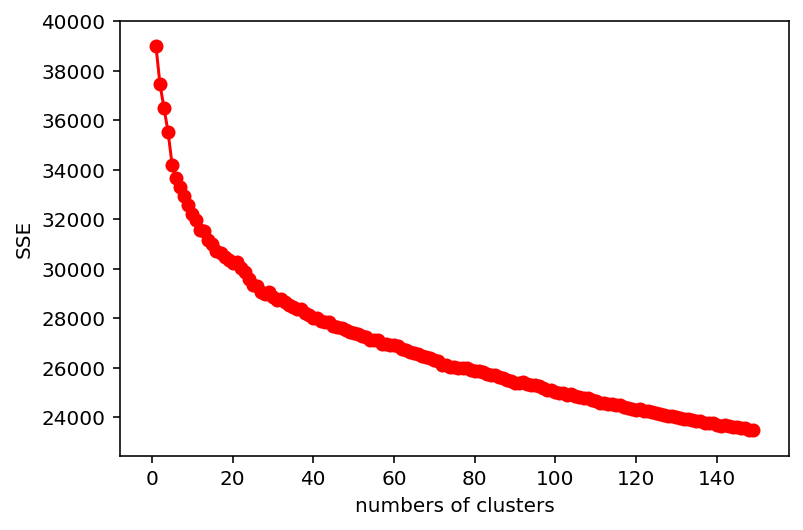

In [57]:
K = range(1,150,1)
totsse = elbow(K)

plt.plot(range(1,150), totsse, c = "r")
plt.scatter(range(1,150), totsse, c = "r")
plt.ylabel("SSE")
plt.xlabel("numbers of clusters")

In [58]:
np.save("./SSE_k_mean.npy", totsse)

## Run K-means with 12 clusters

In [260]:
k = 12
cl, c, Dij = KMeans(tor_data, K=k)

coveraged 30
K-means example with 1,950 points in dimension 576, K = 12:
Timing for 31 iterations: 1.38532s = 100 x 0.01385s



### Printing out the resulting Clusters! 

In [261]:
for i in range(k):
    print("group%d:"%i, np.array(L)[np.where(cl.numpy()==i)])
#     print("distance from the center:")
#     print("group%d:"%i, np.round(np.sqrt(Dij[:,i]))[np.where(cl.numpy()==i)])

group0: ['囧' '向' '匯' '匴' '圄' '匾' '呴' '圁' '卩' '囮' '图' '固' '囪' '周' '囿' '圚' '両' '厘'
 '冏' '喦' '因' '囹' '司' '反' '圈' '凤' '凵' '圆' '匈' '函' '囵' '囷' '圉' '圜' '冈' '凶'
 '凼' '同' '圔' '圖' '囗' '內' '匐' '凹' '冒' '凰' '圂' '囫' '匣' '叵' '厴' '围' '厔' '园'
 '丙' '口' '困' '匟' '囤' '圃' '呂' '匜' '卤' '厨' '团' '回' '圊' '囡' '囝' '匽' '咼' '匰'
 '囚' '圇' '國' '圛' '囥' '勗' '問' '囱' '圍' '壓' '囟' '厎' '兩' '園' '凾' '厦' '南' '厤'
 '匱' '圓' '區' '圌' '四' '夙' '国' '團' '匮']
group1: ['嚕' '咶' '嘒' '唁' '嗒' '咭' '唈' '嘎' '哱' '哺' '哠' '啅' '嘴' '嚝' '咯' '嗔' '嗑' '嘬'
 '啥' '啿' '喑' '喰' '嗿' '喃' '嘄' '嗝' '凅' '嗆' '嚾' '唭' '嚐' '喟' '唄' '喝' '堕' '嚎'
 '唷' '喂' '唅' '囋' '喒' '嚏' '嗅' '咱' '哏' '唱' '啃' '嘳' '响' '噲' '咕' '喀' '喨' '唶'
 '咍' '嗄' '嘈' '啗' '喧' '啍' '啽' '嗚' '嘔' '吗' '喎' '噌' '唔' '噶' '咡' '啧' '喈' '墮'
 '咺' '噂' '哈' '嗩' '嘱' '原' '噙' '嗐' '嘓' '呫' '哼' '凔' '噎' '噜' '噫' '咆' '哨' '咀'
 '噹' '噳' '嗬' '喳' '嚧' '嗤' '噆' '呜' '咁' '喭' '噣' '噥' '嗋' '嗜' '喁' '噱' '凊' '喏'
 '嗃' '噴' '唣' '嗢' '哃' '嘖' '嘻' '凋' '嚙' '嘀' '嚄' '嚆' '啁' '唚' '嗊' '喤']
group2: ['喌' '冻' '夾' '丘' '叱' '兀' '乖' '凇' '劦' '刃' '冂' '丞' '另' '叮' '刁' '准' '冘' 

## Using PCA vectors as the axis to plot the results

The clustering is happening in an extremely high dimensional space. We would like to visualize the clusters. One idea is to reduce the dimension of the feature space using PCA and plot the clusters along the eigenvectors that explain the most variance.

In [242]:
num = 3
X = tor_data

X_mean = torch.mean(X,0)
X = X - X_mean.expand_as(X)
U,S,V = torch.svd(torch.t(X))
C = torch.mm(X,U[:,:num])

([], <a list of 0 Text yticklabel objects>)

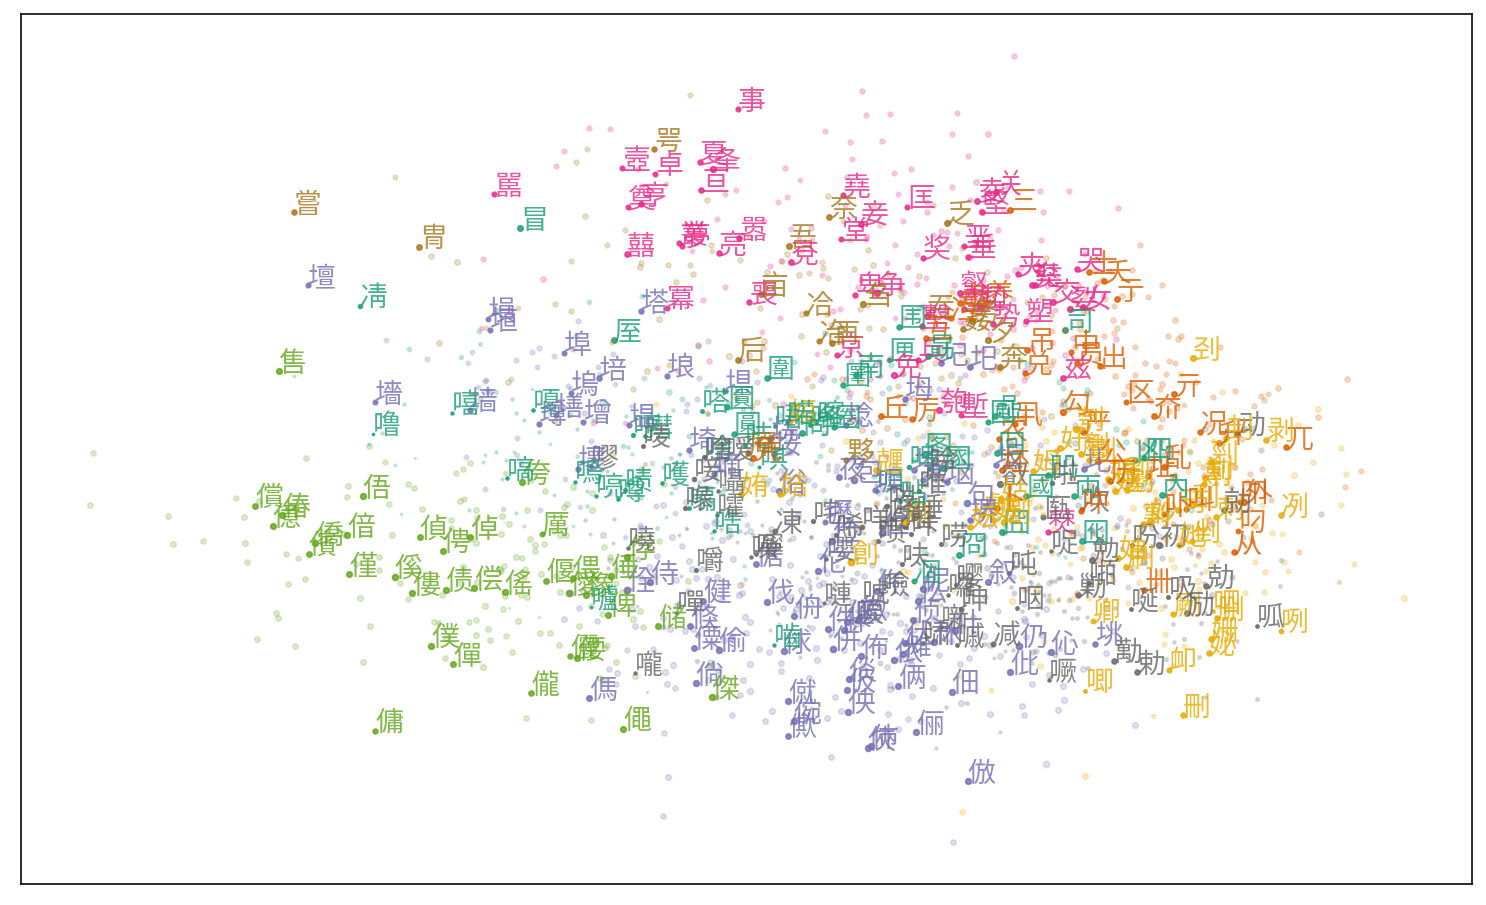

In [271]:
fig = plt.figure(figsize=(13,8))

cmap = plt.cm.get_cmap("Dark2", k)
for i in range(len(C)):
   
    if i%5==0:
        plt.scatter(C.cpu()[i,0], C.cpu()[i,1], s = 2*(C.cpu()[i,2]-min(C.cpu()[:,2]))
                , c = [cmap(cl.cpu()[i].numpy())], 
                 alpha = 0.8)
        
        plt.annotate(L[i], (C.cpu()[i,0], C.cpu()[i,1]), color = cmap(cl.cpu()[i].numpy()),
                     fontproperties=prop, size = 14, alpha = 0.8)
    else:
         plt.scatter(C.cpu()[i,0], C.cpu()[i,1], s = 2*(C.cpu()[i,2]-min(C.cpu()[:,2]))
                , c = [cmap(cl.cpu()[i].numpy())], 
                 alpha = 0.2)

plt.xticks([],[])
plt.yticks([],[])
# plt.savefig(data_saving_path + "/cluster_results_k_%d.png"%k)

### However the top three PCA vectors only count 5.5% of the variance

tensor(0.0552)


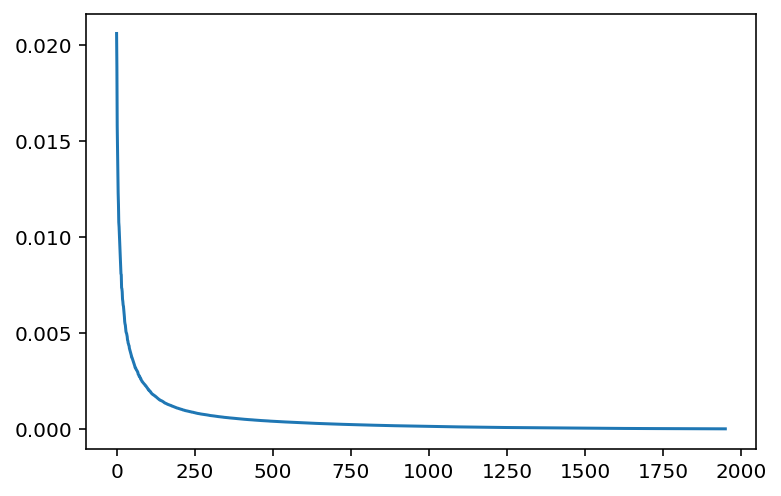

In [139]:
plt.plot(S/sum(S))
print(sum(S[:3]/sum(S)))

## Scatter plot using T-SNE


T-SNE has a perplexity parameter. Here we estimate the optimal perplexity

In [ ]:
## uncomment here to find the best perplexity

# p_list = [2,5,10,50,100,200]
# X_EMB = []
# for i in p_list:
#     X_embedded = TSNE(n_components=2,perplexity=i).fit_transform(X)
#     fig = plt.figure(figsize = (8,8))
    
#     plt.scatter(X_embedded[:,0], X_embedded[:,1])
#     plt.show()
#     X_EMB.append(X_embedded)

### Using preplexity = 50

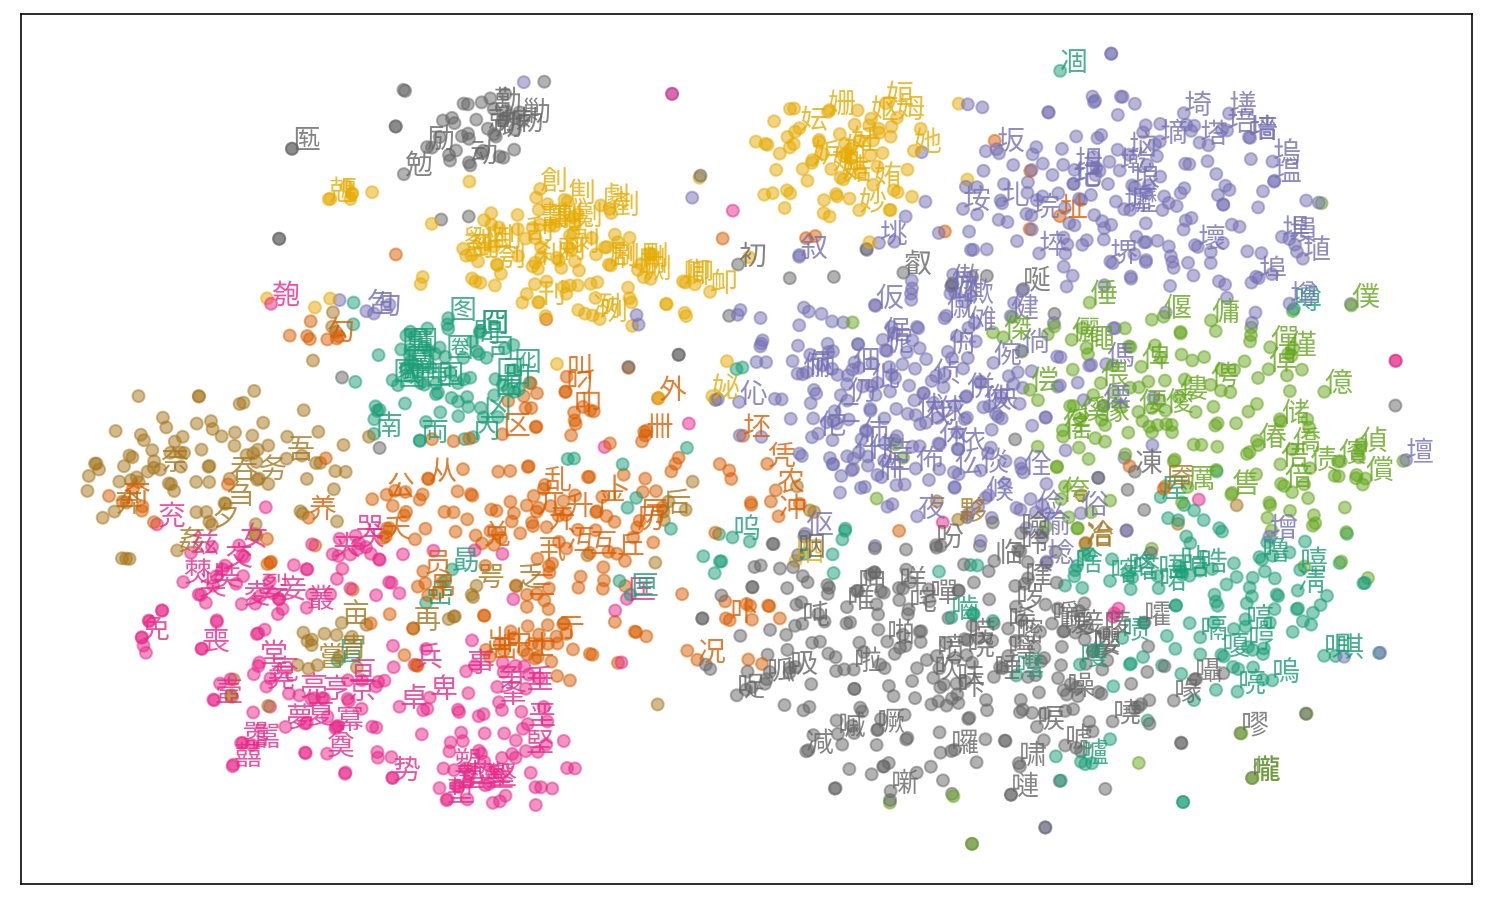

In [280]:
X_embedded = TSNE(n_components=2,perplexity=50).fit_transform(X)

fig = plt.figure(figsize=(13,8))

ax = fig.add_subplot(111)
ax.scatter(X_embedded[:,0], X_embedded[:,1], 
           c = cmap(cl.cpu().numpy()), alpha = 0.5)
cmap = plt.cm.get_cmap("Dark2", k)
for i in range(len(C)):
   
    if i%5==0:
        ax.text(X_embedded[i,0], X_embedded[i,1],
                 L[i], color = cmap(cl.cpu()[i].numpy()),
                 fontproperties=prop, size = 14, alpha = 0.8)
plt.xticks([],[])
plt.yticks([],[])
# plt.show()
plt.savefig(data_saving_path + "/cluster_results_Tsn_k_%d.png"%k)